In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import re
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

LECTURE ET CONVERSION DU FICHIER

In [ ]:
fn_data = 'data.json'

df = pd.read_json(fn_data, encoding='utf8')

#Conversion du .json en csv
df.to_csv("data.csv", index=False)



```
# Ce texte est au format code
```

NETTOYAGE DE LA COLONNE LIEU

In [ ]:
#---------------------------------------------------------------------------------------------------------
#NETTOYAGE DE LA COLONNE LIEU
#----------------------------------------------------------------------------------------------------------

# extraction des lieux et salaires min et max a partir de la colonne lieu
split_df = pd.DataFrame(df['lieu'].tolist(), columns=['location', 'salaire'])

# Ajout des nouvelles colonne au df
df = pd.concat([df, split_df], axis=1)
df = df.drop(['lieu'], axis=1)
df['lieu'] = df['location']
df.drop(['location'], axis=1, inplace=True)

#lieu
df['lieu'] = df['lieu'].apply(lambda x: ''.join(map(str, x)).replace("\n", "").lower())
df['lieu']
#lieu modification 

#Lieu
s = [item for item in df['lieu']]
pat = re.compile(r'^ile.*')
pat2 = re.compile(r'^pari.*')
pat3 = re.compile(r'^france - an.*')
pat4 = re.compile(r'^guyancourt.*')
pat5 = re.compile(r'^île.*')
pat6 = re.compile(r'^la défense,*')
pat7 = re.compile(r'^neuilly sur seine*')
pat8 = re.compile(r'^paray vieille poste*')
pat9 = re.compile(r'^rueil *')
list_lieu = []
for item in s:
    #recherche dans la list les lines lieu qui commence par pat
    test = bool(pat.search(item))
    test2= bool(pat2.search(item))
    test3= bool(pat3.search(item)) 
    test4= bool(pat4.search(item))
    test5= bool(pat5.search(item))
    test6= bool(pat6.search(item))
    test7= bool(pat7.search(item))
    test8= bool(pat8.search(item))
    test9= bool(pat9.search(item))
   #remplacer chaque line de lieu non hemogenic par une seul meme valeur
    if test == True:
        list_lieu.append('île-de-france')
    elif test2 == True:
        list_lieu.append('paris')
    elif test3 == True:
        list_lieu.append('antony') 
    elif test4 == True:
        list_lieu.append('guyancourt')
    elif test6 == True:
        list_lieu.append('la defense')
    elif test7 == True:
        list_lieu.append('neuilly-sur-seine')
    elif test8 == True:
        list_lieu.append('paray-vieille-poste')  
    elif test9 == True:
        list_lieu.append('rueil-malmaison')   
        
        
    else:
        list_lieu.append(item)
df['lieu'] = list_lieu
#print(df['lieu'].head(230).sort_values(ascending = True))


NETTOYAGE DE LA COLONNE COMPETENCES

In [ ]:
# Suppression des caracteres non désirées dans la colonne compétence et rajout d'une virgule apres chaque élements "\n"
df['competences'] = df['competences'].apply(lambda x: ','.join(map(str, x))
                                    .replace("\n", " ")
                                    .replace(" ", "")
                                    .replace(",", ", "))
#df['competences']

::NETTOYAGE DE LA COLONNE SALAIRE ET SPLIT EN DEUX PARTIES

In [ ]:
#on retire tout ce qui n'est pas un chiffre pour pouvoir convertir en float
df['salaire'] = df['salaire'].apply(lambda x: ''.join(map(str, x))
                            .replace("\n", "").replace(" / an", "")
                            .replace("/an selon profil", "").replace(" €", "")
                            .replace('.000,00', '000.00') 
                            if type(x) == str else np.nan)

df[['salaire_min', 'salaire_max']] = df.salaire.str.split(" - ", expand=True)

#on convertit en float
df['salaire_min'] = df['salaire_min'].apply(lambda x: float(x))
df['salaire_max'] = df['salaire_max'].apply(lambda x: float(x))

NETTOYAGE ET SPLIT TYPE DE POSTE EN TYPE DE CONTRACT ET TYPE CLIENT

In [ ]:
#colonnes entreprise et type de contrat

#séparation de la liste dans la colonne "Type de poste" en plusieurs colonnes
#identification des colonnes utiles
split_df = pd.DataFrame(df['Type de poste'].tolist(), columns=['col1', 'col2', 'entreprise', 'type_poste_1', 'type_client', 'type_poste_2', 'col7', 'type_contrat'])
split_df.isnull().sum() 

#supression des caractères inutiles comme \n
#on saute les valeurs None qu'on remplace par Nan
split_df = split_df[['entreprise', 'type_client', 'type_poste_1', 'type_poste_2', 'type_contrat']]
split_df['type_poste_1'] = split_df['type_poste_1'].apply(lambda x: ''.join(map(str, x)).replace("\n", ""))
split_df['type_poste_2'] = split_df['type_poste_2'].apply(lambda x: ''.join(map(str, x)).replace("\n", "") if type(x) == str else np.nan)
split_df['type_contrat'] = split_df['type_contrat'].apply(lambda x: ''.join(map(str, x)).replace("\n", "") if type(x) == str else np.nan)
split_df['entreprise'] = split_df['entreprise'].apply(lambda x: ''.join(map(str, x)).replace("\n", "") if type(x) == str else np.nan)

#on prend la colonne type de poste la plus remplie et on complète les Nan à l'aide des autres colonnes
split_df['type_contrat'] = split_df['type_contrat'].fillna(split_df['type_poste_2'])
split_df['type_contrat'] = split_df['type_contrat'].fillna(split_df['type_poste_1'])

#on supprime les colonnes qui ont servi à remplir la colonne principale
split_df.drop(['type_poste_1','type_poste_2'], axis=1, inplace=True)

#on supprime la mention 'temps plein'
split_df['type_contrat'] = split_df['type_contrat'].str.replace(' - temps plein', '')

#on s'est rendus compte que pour les index 110 et 121, il n'y avait pas de nom d'entreprise
#donc on remplace par Nan
split_df['entreprise'] = split_df['entreprise'].replace(r'^\s*$', np.nan, regex=True)
#split_df.isna().sum() 

#on s'est rendus compte que les noms d'ENGIE et Société Générale était écrit de 2 manières différentes
#donc on homogénise
split_df['entreprise'] = split_df['entreprise'].str.replace('Groupe ENGIE', 'ENGIE').replace('Societe Generale', 'Société générale')
#split_df['entreprise'].unique()

#on traite la colonne type_client
split_df['type_client'] = split_df['type_client'].replace(r'^\s*$', np.nan, regex=True)

#on rajoute au df principal
df = pd.concat([df, split_df], axis=1)

#et on supprime l'ancienne colonne type de poste
df.drop(['Type de poste'], axis=1, inplace=True)
#df

In [ ]:
# extraction des caracteres necessaires dans la colonne date de publication
df['Date de publication'] = df['Date de publication'].apply(lambda x: x.replace("\n", "").replace("postée il y a", ""))
#df['Date de publication']
# extraction de la chaine de caractere apres le nombre de jour et mettre dans colonne "duree"
df["duree"] = df["Date de publication"].str.extract(r'(\d+)(\D+)')[1]
#print(df['duree'])

# extraction de la chaine de caractere numerique et mettre dans colonne "nb_jour"
df['nb_jour'] = df['Date de publication'].str.extract(r'(\d+)').fillna(1).astype(int)
#print(df['duree'])

# ------------------------------------------------------------------------------------------------------------------------------
# recuperer une valeur dans une colonne et appliquer une operation sur lautre en fonction de la valeur de la premiere colonne
# ------------------------------------------------------------------------------------------------------------------------------


# Transformer les valeurs de la colonne duree en liste
col_duree = df['duree'].tolist()

# Transformer les valeurs de la colonne nb_jour en liste
col_nb_jour = df['nb_jour'].tolist()

# Itérer simultanément sur les deux listes  avc la methode zip()
combined_list = list(zip(col_duree, col_nb_jour))

# creation d'une liste vide
modified_combined_list = []

# iterartion sur les element combiner de la list
for element in combined_list:
    if element[0] == ' mois':
        modified_combined_list.append(('mois', element[1] * 31))
    elif element[0] == ' heures':
        modified_combined_list.append(('heures', 0))
    else:
        modified_combined_list.append(element)

# mise du resultat dans liste de tuples
combined_list = modified_combined_list

# extraire la deuxieme partie des tuples car zip() retourne une liste de tuple
col_duree_final = [element[1] for element in combined_list]

# df['nb_jour_final'] = pd.DataFrame(modified_combined_list[1])
df['nb_jour_final'] = pd.DataFrame(col_duree_final)


# extraire la valeur de chaque ligne de nb_jour_final et la mettre dans parametre days="" de time delta
def process_date_list(days_list, reference_date):
    
    new_date_list = []
    #iteartion sur la liste de jours que l'on passe en parametre
    for days in days_list:
        #date  obtenu apres la soustraction du nombre de jour a la date de ref
        new_date = reference_date - timedelta(days=days)
        #mise au format souhaité de la date
        new_date = new_date.strftime("%Y/%m/%d")
        #integration de la date dans une nouvelle liste
        new_date_list.append(new_date)
    return new_date_list


#parametre a donner a la fonction "le dataframe qui contient tout les jours"
days_list = df['nb_jour_final']


#date de reference 
datetime_str = '15/01/2023'
reference_date = datetime.strptime(datetime_str, '%d/%m/%Y')

#fonction jouée avec la liste des jours et la date de reference 
result = process_date_list(days_list, reference_date)

#creation nouvelle colonne date
df["date"] = pd.DataFrame(result) 

In [ ]:
df = df[['Intitulé du poste', 'date', 'competences','entreprise', 'type_client', 'type_contrat', 'lieu', 'salaire_min', 'salaire_max']]
#df

#-------------------------------------------------------------------------------------------------
#NETTOYAGE DE LA COLONNE INTITULE DU POSTE
#-------------------------------------------------------------------------------------------------
# Suppression des caracteres "\n"
df['Intitulé du poste'] = df['Intitulé du poste'].apply( lambda x: ''.join(map(str, x)).replace("\n", ""))
#df['Intitulé du poste']
# Appliquer la fonction `str.lower()` sur chaque ligne
df['Intitulé du poste'] = df['Intitulé du poste'].apply(lambda x: x.lower()
                                                        .replace('(h/f)','')
                                                        .replace("h/f","")
                                                        .replace("f/h","")
                                                        .replace("-","")
                                                        .replace("/", " - ")
                                                        .replace("#3","")
                                                        .replace("data ingenieur","data engineer")
                                                        .replace("alternant","alternance")
                                                        .replace("datascientist","data scientist")                                 
                                                        )

#-------------------------------------------------------------------------------------------------
#NETTOYAGE DES INTITULES EN GENERALISANT LES METIER RECHERCHES SANS ETRE PRECIS
#-------------------------------------------------------------------------------------------------

job_list = ['développeur vba ','développeur java ','développeur angular','responsable développement supply chain','data analyst', 'data scientist' , 'business analyst', 'data engineer', 'senior data engineer', 'data quality manager', 'stage', 'alternance', 'responsable technique web']
def replace_job_with_job_list(df, column, job_list):
    for i, job in enumerate(job_list):
        df.loc[df[column].str.contains(job, na=False), column] = job_list[i]
    return df
replace_job_with_job_list(df, 'Intitulé du poste', job_list)

#-------------------------------------------------------------------------------------------------
#SUPPRESSION DES STOPS WORDS
#-------------------------------------------------------------------------------------------------

#import nltk
#from nltk.corpus import stopwords
#stop = stopwords.words(['french','english'])



#df['Intitulé du poste'] = df['Intitulé du poste'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#df

,Intitulé du poste,date,competences,entreprise,type_client,type_contrat,lieu,salaire_min,salaire_max
0,data analyst,2022/12/25,"sql, t-sql, outils",Sept Lieues SAS,Cabinet de recrutement,CDI,paris,NaN,NaN
1,data analyst,2022/12/15,"support, outils, agile, design, bigdata",EDF France,Client final,CDI,paris,NaN,NaN
2,data analyst,2022/12/19,"crm, dataquality, sql, sas, python",Hermès,Client final,CDI,paris,NaN,NaN
3,data analyst,2022/12/25,"si, support, sap",TEREOS,Client final,CDI,moussy-le-vieux,NaN,NaN
4,data analyst,2023/01/12,"outils, support, decisionnel, sql, test",Safran-Group,Client final,CDI,france,NaN,NaN
...,...,...,...,...,...,...,...,...,...
225,sap fiori developer,2022/12/19,"sap, abap, progiciel, système, support",ENGIE,Client final,CDI,saint-ouen,NaN,NaN
226,engie digital architecte données,2023/01/12,"digital, outils, securité, sécurité, t-sql",ENGIE,Client final,CDI,paris,NaN,NaN
227,quality assurance lead qa lead acceptance,2023/01/15,"test, serveur, jquery, mobile, tdd",Francaise des jeux,Client final,CDI,boulogne-billancourt,NaN,NaN
228,data scientist,2022/12/30,"nosql, unix, java, machinelearning, linux",BEEZEN,ESN,CDI,neuilly-sur-seine,38000.0,50000.0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#recherche de mot avec un tiret
pattern = "(?u)\\b[\\w-]+\\b"
vectorizer = CountVectorizer(token_pattern=pattern)

tokens = vectorizer.fit_transform(df['competences'])
vectorizer.get_feature_names_out()
tokens.toarray()

# créer un nouveau DataFrame à partir de X.toarray()
df_tokens = pd.DataFrame(tokens.toarray(), columns=vectorizer.get_feature_names_out())

# Ajouter les colonnes extraites à un dataframe existant
df_full = pd.concat([df, df_tokens], axis=1)

#df_full

ANALYSE UNIVARIEE

In [ ]:
#compétences les plus recherchées
dfcomp = df_tokens.sum(axis=0).sort_values(ascending=False).head(20)
dfcomp

outils            80
support           70
si                46
bigdata           45
securité          35
python            33
sql               30
sécurité          30
système           30
cloud             27
marketing         26
agile             24
digital           24
datamanagement    23
infrastructure    20
web               18
réseaux           18
communication     17
java              17
devops            14
dtype: int64

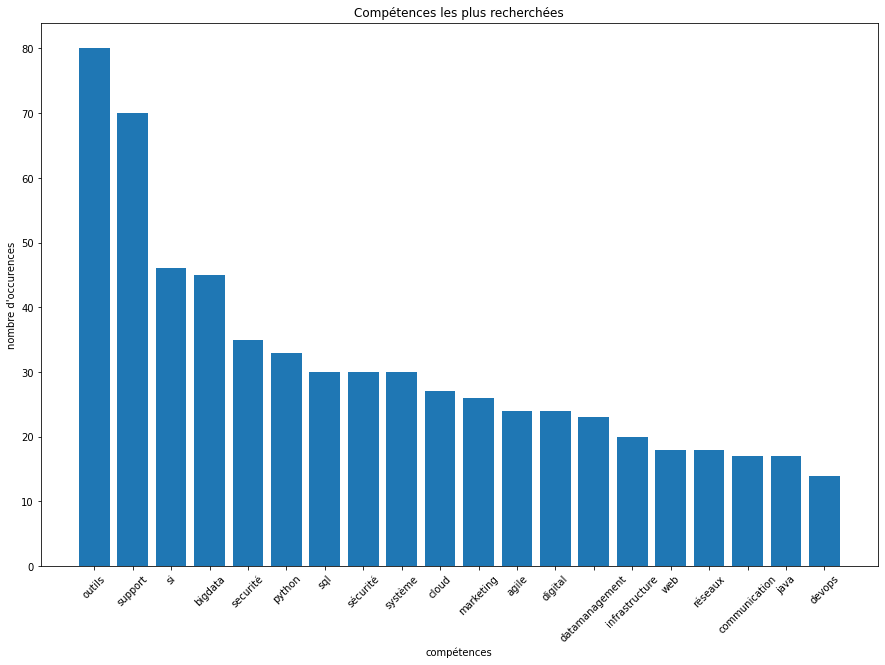

In [ ]:
dfcomp = pd.DataFrame(dfcomp)

# définir les séries de données
x = dfcomp[0].index
y = dfcomp[0].values

# créer un objet figure et un objet Axes
fig, ax = plt.subplots()

# utiliser la méthode bar pour tracer le graphique
ax.bar(x, y)

# ajouter un titre et des étiquettes d'axe
ax.set_title("Compétences les plus recherchées")
ax.set_xlabel("compétences")
ax.set_ylabel("nombre d'occurences")

# faire pivoter les étiquettes d'axe X de 45°
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.rcParams["figure.figsize"] = (15, 10)
# afficher le résultat
plt.show()


Après le classement des compétences par fréquence d'apparition, il ressort que les compétences "outils", "support", "systeme" et certainement d'autres ne sont pas pertinentes
Il serait peut-être judicieux de faire une analyse plus fine et voir si elles sont associées avec d'autres groupes de mots (collocation)
Ou bien les supprimer et garder le mot le plus important de cette collocation


In [ ]:
#entreprises qui recrutent le plus
dfent = df_full['entreprise'].value_counts().sort_values(ascending=False).head(10)
dfent

Société générale           38
Uniware Global Services    20
Safran-Group               15
Naval Group                 9
FED IT                      8
TRIMANE                     8
ENGIE                       8
EDF France                  7
Natixis                     6
Vinci                       6
Name: entreprise, dtype: int64

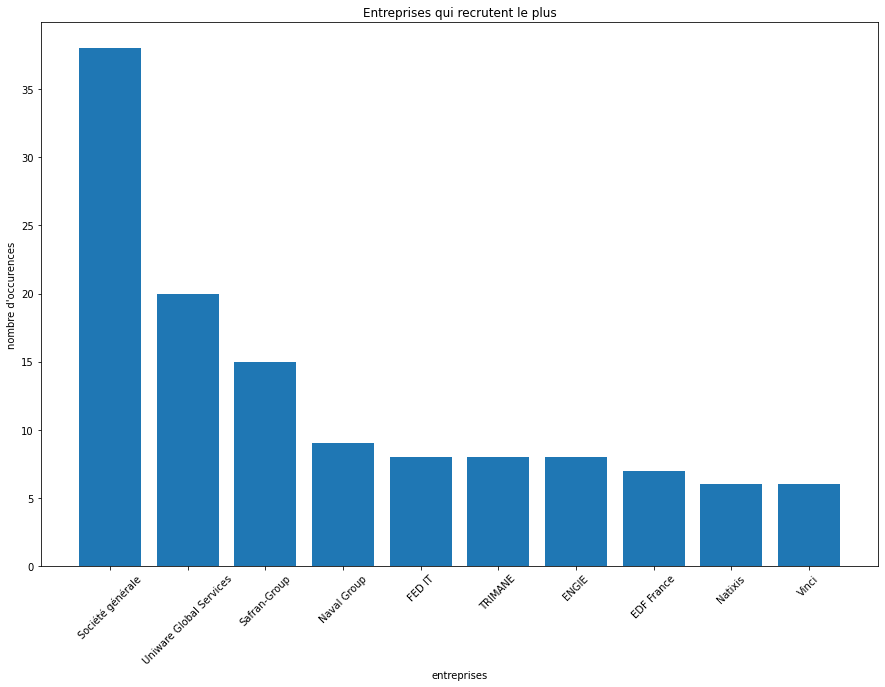

In [ ]:
dfent = pd.DataFrame(dfent)


# définir les séries de données
x = dfent['entreprise'].index
y = dfent['entreprise'].values

# créer un objet figure et un objet Axes
fig, ax = plt.subplots()

# utiliser la méthode bar pour tracer le graphique
ax.bar(x, y)

# ajouter un titre et des étiquettes d'axe
ax.set_title("Entreprises qui recrutent le plus")
ax.set_xlabel("entreprises")
ax.set_ylabel("nombre d'occurences")

# faire pivoter les étiquettes d'axe X de 45°
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.rcParams["figure.figsize"] = (15, 10)
# afficher le résultat
plt.show()

In [ ]:
#types de contrat les plus fréquents
dfcontrat = df_full['type_contrat'].value_counts().sort_values(ascending=False)
dfcontrat

CDI                                203
Stage                               17
CDD/Intérim                          4
Contrat de professionnalisation      3
Contrat d'apprentissage              3
Name: type_contrat, dtype: int64

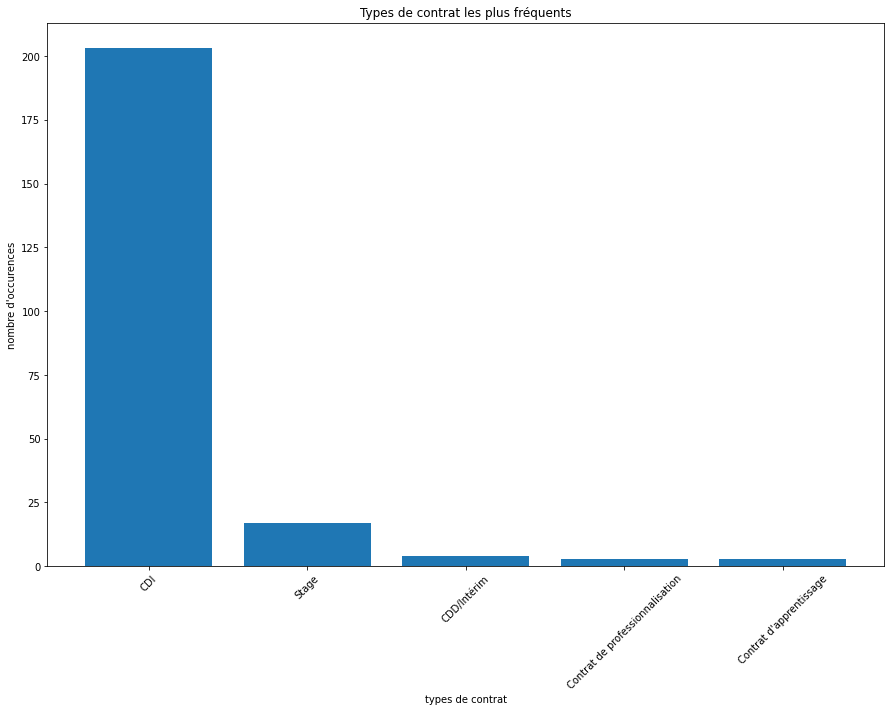

In [ ]:
dfcontrat = pd.DataFrame(dfcontrat)

# définir les séries de données
x = dfcontrat['type_contrat'].index
y = dfcontrat['type_contrat'].values

# créer un objet figure et un objet Axes
fig, ax = plt.subplots()

# utiliser la méthode bar pour tracer le graphique
ax.bar(x, y)

# ajouter un titre et des étiquettes d'axe
ax.set_title("Types de contrat les plus fréquents")
ax.set_xlabel("types de contrat")
ax.set_ylabel("nombre d'occurences")

# faire pivoter les étiquettes d'axe X de 45°
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# afficher le résultat
plt.show()

In [ ]:
#types de client les plus fréquents
dfclient = df_full['type_client'].value_counts().sort_values(ascending=False)
dfclient

Client final               145
ESN                         36
Cabinet de recrutement      22
Cabinet de conseil          10
Administration Publique      4
Editeur de logiciel          4
Name: type_client, dtype: int64

In [ ]:
#où sont situés la plupart des postes
dflieu = df_full['lieu'].value_counts().sort_values(ascending=False)
dflieu.head(15)

paris                    72
île-de-france            35
la defense               17
fontenay-sous-bois       15
bagneux                   9
saint-ouen                7
neuilly-sur-seine         7
rueil-malmaison           6
nanterre                  4
courbevoie                4
saint-germain-en-laye     4
boulogne-billancourt      4
puteaux                   4
suresnes                  4
levallois-perret          4
Name: lieu, dtype: int64

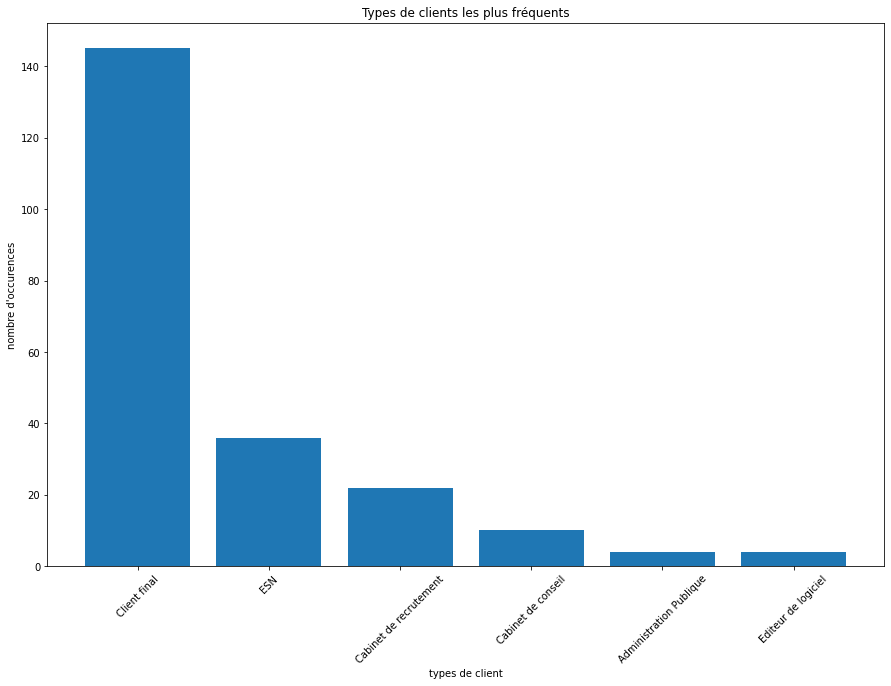

In [ ]:
dfclient = pd.DataFrame(dfclient)

# définir les séries de données
x = dfclient['type_client'].index
y = dfclient['type_client'].values

# créer un objet figure et un objet Axes
fig, ax = plt.subplots()

# utiliser la méthode bar pour tracer le graphique
ax.bar(x, y)

# ajouter un titre et des étiquettes d'axe
ax.set_title("Types de clients les plus fréquents")
ax.set_xlabel("types de client")
ax.set_ylabel("nombre d'occurences")

# faire pivoter les étiquettes d'axe X de 45°
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# afficher le résultat
plt.show()

ANALYSE BIVARIEE

In [ ]:
df_table = df.drop(['type_client'], axis=1)
df_table['nombre_observations'] = df_full['type_client'].value_counts()
df_table

,Intitulé du poste,date,competences,entreprise,type_contrat,lieu,salaire_min,salaire_max,nombre_observations
0,data analyst,2022/12/25,"sql, t-sql, outils",Sept Lieues SAS,CDI,paris,NaN,NaN,NaN
1,data analyst,2022/12/15,"support, outils, agile, design, bigdata",EDF France,CDI,paris,NaN,NaN,NaN
2,data analyst,2022/12/19,"crm, dataquality, sql, sas, python",Hermès,CDI,paris,NaN,NaN,NaN
3,data analyst,2022/12/25,"si, support, sap",TEREOS,CDI,moussy-le-vieux,NaN,NaN,NaN
4,data analyst,2023/01/12,"outils, support, decisionnel, sql, test",Safran-Group,CDI,france,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
225,sap fiori developer,2022/12/19,"sap, abap, progiciel, système, support",ENGIE,CDI,saint-ouen,NaN,NaN,NaN
226,engie digital architecte données,2023/01/12,"digital, outils, securité, sécurité, t-sql",ENGIE,CDI,paris,NaN,NaN,NaN
227,quality assurance lead qa lead acceptance,2023/01/15,"test, serveur, jquery, mobile, tdd",Francaise des jeux,CDI,boulogne-billancourt,NaN,NaN,NaN
228,data scientist,2022/12/30,"nosql, unix, java, machinelearning, linux",BEEZEN,CDI,neuilly-sur-seine,38000.0,50000.0,NaN


In [ ]:
#quelles entreprises recrutent, pour quel poste et quel salaire, triées par salaire max
df_table = df.drop(['type_client'], axis=1)
df_table.dropna(inplace=True)
table = pd.pivot_table(df_table, index=['entreprise', 'Intitulé du poste'])
table.sort_values('salaire_max', ascending=False, inplace=True)
table

salaire_max  \
entreprise              Intitulé du poste                                                 
Selescope               ingénieur d’affaires  -  business developer–data       100000.0   
                        business developer – ia  -  data analytics             100000.0   
MR SEARCH               business analyst                                        80000.0   
Uniware Global Services architecte poste de travail                             70000.0   
Hays France             chef de projets data  analytics                         70000.0   
Key Consulting          data scientist                                          70000.0   
MR SEARCH               responsable technique web                               70000.0   
Selescope               consultant data                                         70000.0   
FED IT                  data scientist                                          65000.0   
Synchrone               développeur java  -  j2ee  – paris (75)                 65000.0   
FED IT                  responsable développement supply chain ()  cdi          62000.0   
Uniware Global Services ingénieur cloud opensource                              60000.0   
                        ingénieur de production $u                              60000.0   
                        ingénieur de production cloud                           60000.0   
                        architecte infrastructure it                            60000.0   
                        ingénieur devops                                        60000.0   
                        ingénieur cloud azure                                   60000.0   
                        ingénieur réseau - sécurité                             60000.0   
                        ingénieur réseau cisco                                  60000.0   
                        ingénieur docker - kubernetes - jenkins - ansible       60000.0   
                        ingénieurs middleware                                   60000.0   
                        expert middleware                                       60000.0   
Nexton Consulting       chef de projet data                                     60000.0   
Michael Page            responsable etudes et projets si                        60000.0   
Uniware Global Services ingénieur cloud aws                                     56000.0   
FED IT                  data analyst                                            56000.0   
EXPERTEAM               ingénieur systèmes windows                              55000.0   
Uniware Global Services ingénieur réseaux et sécurité                           55000.0   
                        ingénieur système unix - linux                          55000.0   
                        ingénieur système vmware                                55000.0   
                        ingénieur virtualisation                                55000.0   
                        ingénieurs de production unix - linux - windows         55000.0   
Synchrone               développeur vba  -  excel  – paris (75)                 50000.0   
                        développeur angular  – paris (75)                       50000.0   
BEEZEN                  data scientist                                          50000.0   
FED IT                  business analyst                                        45000.0   

                                                                            salaire_min  
entreprise              Intitulé du poste                                                
Selescope               ingénieur d’affaires  -  business developer–data        70000.0  
                        business developer – ia  -  data analytics              70000.0  
MR SEARCH               business analyst                                        50000.0  
Uniware Global Services architecte poste de travail                             50000.0  
Hays France             chef de projets data  analytics                      

In [ ]:
dfnan = df_full.dropna()

#types de clients qui rémunèrent le mieux
df_client = dfnan.groupby(['type_client']).median()
df_client['nombre_observations'] = df_full['type_client'].value_counts()
df_client[['salaire_min', 'salaire_max', 'nombre_observations']].sort_values('salaire_min', ascending=False)
#données présentes uniquements pour 3 types de client

,salaire_min,salaire_max,nombre_observations
type_client,,,
Cabinet de recrutement,56000.0,62000.0,22
ESN,40000.0,60000.0,36
Cabinet de conseil,30000.0,60000.0,10


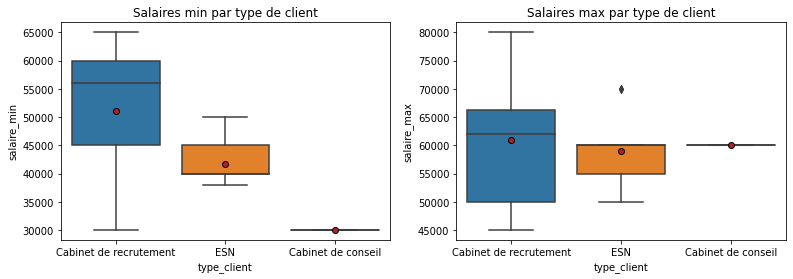

In [ ]:
plt.figure(figsize=(13,4)) 
plt.subplot(1,2,1)
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'} 
sns.boxplot('type_client','salaire_min',data=dfnan, showmeans=True, meanprops=meanprops).set(title='Salaires min par type de client') 
plt.subplot(1,2,2) 
sns.boxplot('type_client','salaire_max',data=dfnan, showmeans=True, meanprops=meanprops).set(title='Salaires max par type de client')
plt.show()

In [ ]:
#postes les mieux rémunérés
df_poste = df_full.dropna().groupby(['Intitulé du poste']).median()
df_poste['nombre_observations'] = df_full['Intitulé du poste'].value_counts()
postes_mieux_remuneres = df_poste[['salaire_min', 'salaire_max', 'nombre_observations']].loc[df_poste['nombre_observations'] >= 2].sort_values('salaire_min', ascending=False)
postes_mieux_remuneres
#besoin de généraliser davantage les intitulés de poste

Index(['salaire_min', 'salaire_max', 'nombre_observations'], dtype='object')

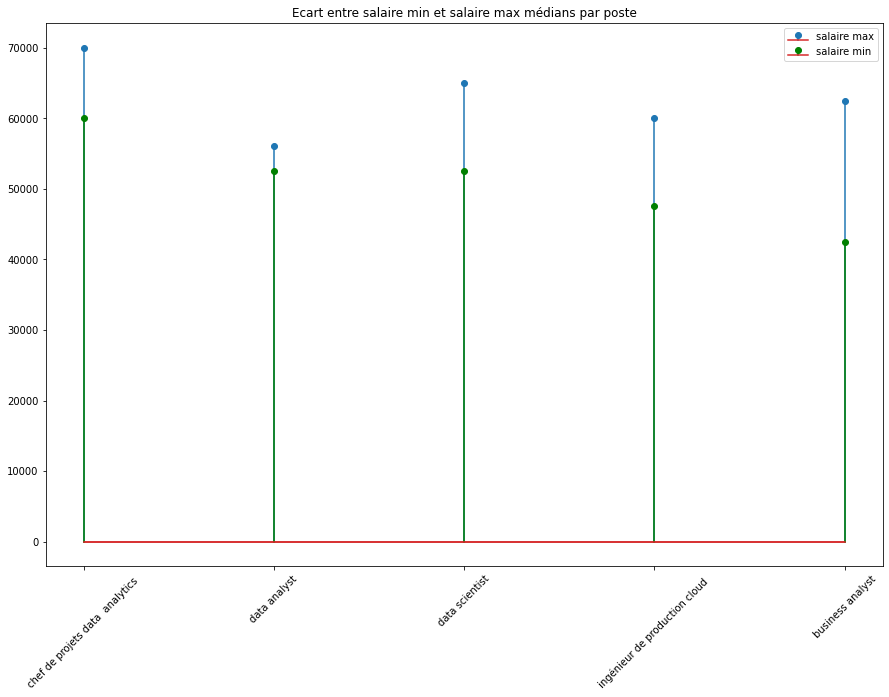

In [ ]:
# make data
np.random.seed(3)
x = postes_mieux_remuneres.index.to_numpy()


ya = postes_mieux_remuneres[['salaire_max']].to_numpy()
yb = postes_mieux_remuneres[['salaire_min']].to_numpy()

# plot
fig, ax = plt.subplots()

#plt.stem(x, ya, 'b', markerfmt='o', label='salaire max')
#plt.stem(x, yb, 'g', markerfmt='o', label='salaire min')

markerline, stemlines, baseline = plt.stem(x, ya, markerfmt='o', label='salaire max')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'solid')

markerline, stemlines, baseline = plt.stem(x, yb, markerfmt='go', label='salaire min')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'solid')
ax.set_title("Ecart entre salaire min et salaire max médians par poste")
plt.xticks(rotation=45)

plt.legend()
plt.show()

In [ ]:
#compétences recherchées pour les postes les mieux rémunérés
df_poste_comp = df[~df['Intitulé du poste'].isin(postes_mieux_remuneres.columns)]
df_poste_comp = df_full.dropna().groupby(['Intitulé du poste']).sum()
df_poste_comp.drop(['salaire_min', 'salaire_max'], axis=1, inplace=True)

df_poste_comp['nombre_competences'] = df_poste_comp.astype(bool).sum(axis=1)
df_poste_comp['nombre_observations'] = df_full['Intitulé du poste'].value_counts()

df_poste_comp = df_poste_comp.sort_values("nombre_observations", ascending=False)
df_poste_comp = df_poste_comp.drop(df_poste_comp.index[5:])
df_poste_comp = df_poste_comp.loc[:, (df_poste_comp != 0).any(axis=0)]

df_poste_comp#.style.background_gradient(cmap='Greens')

,agile,basesdedonnées,bigdata,businessintelligence,businessobjects,cloud,datamanagement,devops,digital,intelligenceartificielle,...,si,sql,sqlserver,support,sécurité,t-sql,unix,ux,nombre_competences,nombre_observations
Intitulé du poste,,,,,,,,,,,,,,,,,,,,,
data analyst,0,2,0,2,2,0,4,0,0,0,...,0,2,0,2,0,2,0,0,7,21
data scientist,1,0,0,0,0,0,2,0,0,0,...,0,0,0,2,0,0,1,0,10,17
business analyst,0,0,1,1,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,6,11
ingénieur de production cloud,0,0,0,0,0,2,0,2,0,0,...,1,0,1,0,2,0,0,0,6,2
chef de projets data analytics,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,2,5,2


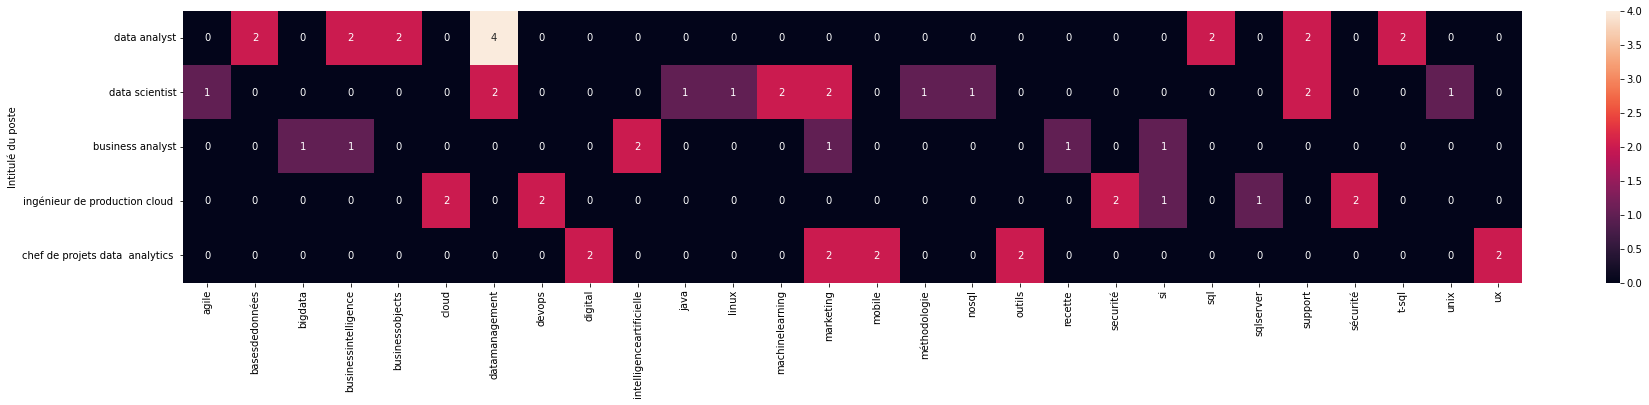

In [ ]:
df_poste_comp.drop(['nombre_competences', 'nombre_observations'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(30,5))
sns.heatmap(df_poste_comp, annot=True)

In [ ]:
#compétences les plus demandées pour les salaires les plus élevés

df_salaire_comp = df_full.dropna().groupby(['salaire_max']).sum()
df_salaire_comp.drop(['salaire_min'], axis=1, inplace=True)
#comme il y a beaucoup de colonnes compétences, on cherche à savoir combien de compétences sont présentes dans chaque ligne
#attention en cas de disparité entre les annonces, cette valeur peut être fortement influencée par le nombres d'observations
df_salaire_comp['nombre_competences'] = df_salaire_comp.astype(bool).sum(axis=1)
df_salaire_comp['nombre_observations'] = df_full['salaire_max'].value_counts()
df_salaire_comp = df_salaire_comp.loc[:, (df_salaire_comp != 0).any(axis=0)].sort_values('salaire_max', ascending=False)
df_salaire_comp.loc[df_salaire_comp['nombre_observations'] >= 2]#.style.background_gradient(cmap='Blues')

,agile,angularjs,basesdedonnées,bigdata,businessintelligence,businessobjects,cft,cisco,cloud,communication,...,unix,ux,vba,vmware,wan,web,weblogic,windows,nombre_competences,nombre_observations
salaire_max,,,,,,,,,,,,,,,,,,,,,
70000.0,1,0,0,0,0,0,0,0,1,0,...,0,2,0,0,0,1,0,0,17,7
65000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,8,3
62000.0,0,0,2,1,2,0,0,0,1,1,...,0,0,0,0,0,0,0,0,8,3
60000.0,1,0,0,0,0,0,1,1,4,0,...,2,0,0,0,0,1,1,1,32,14
55000.0,0,0,0,0,0,0,0,0,1,0,...,2,0,0,2,1,0,0,3,17,6
50000.0,1,1,0,0,0,2,0,0,0,0,...,1,0,1,0,0,2,0,0,17,5


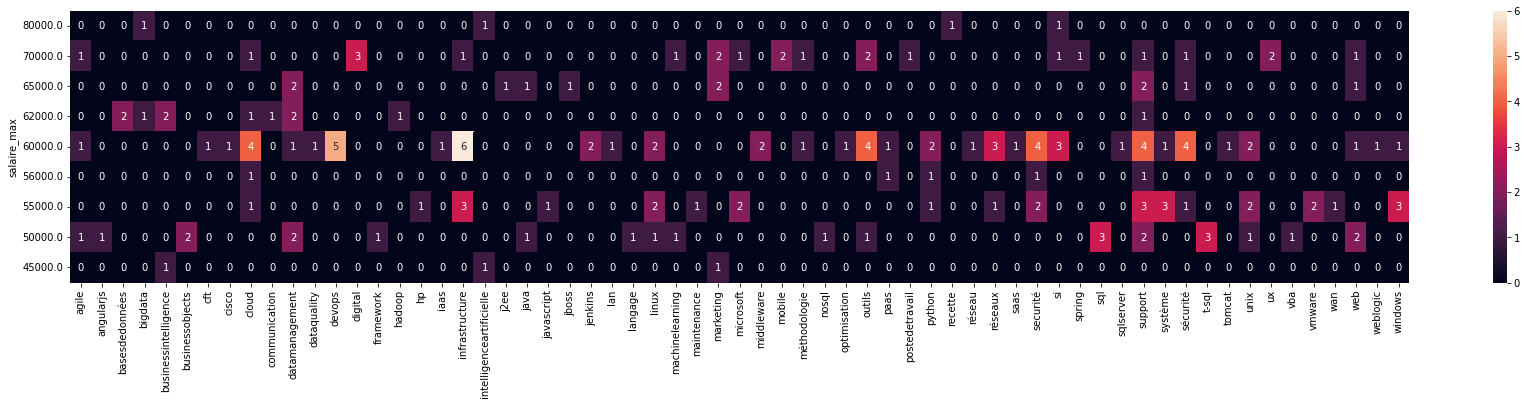

In [ ]:
df_salaire_comp.drop(['nombre_competences', 'nombre_observations'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(30,5))
sns.heatmap(df_salaire_comp, annot=True)

In [ ]:
#lien entre compétences et type de contrat
df_contrat = df_full.dropna().groupby(['type_contrat']).sum()
df_contrat.drop(['salaire_min', 'salaire_max'], axis=1, inplace=True)
#comme il y a beaucoup de colonnes compétences, on cherche à savoir combien de compétences sont présentes dans chaque ligne
#attention en cas de disparité entre les annonces, cette valeur peut être fortement influencée par le nombres d'observations
df_contrat['nombre_competences'] = df_contrat.astype(bool).sum(axis=1)
df_contrat['nombre_observations'] = df_full['type_contrat'].value_counts()

df_contrat = df_contrat.loc[:, (df_contrat != 0).any(axis=0)]#.sort_values('salaire_max', ascending=False)
df_contrat.loc[df_contrat['nombre_observations'] >= 2]#.style.background_gradient(cmap='Reds')

,agile,angularjs,basesdedonnées,bigdata,businessintelligence,businessobjects,cft,cisco,cloud,communication,...,unix,ux,vba,vmware,wan,web,weblogic,windows,nombre_competences,nombre_observations
type_contrat,,,,,,,,,,,,,,,,,,,,,
CDD/Intérim,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,5,4
CDI,3,1,2,2,3,0,1,1,8,1,...,5,2,1,2,1,5,1,4,62,203


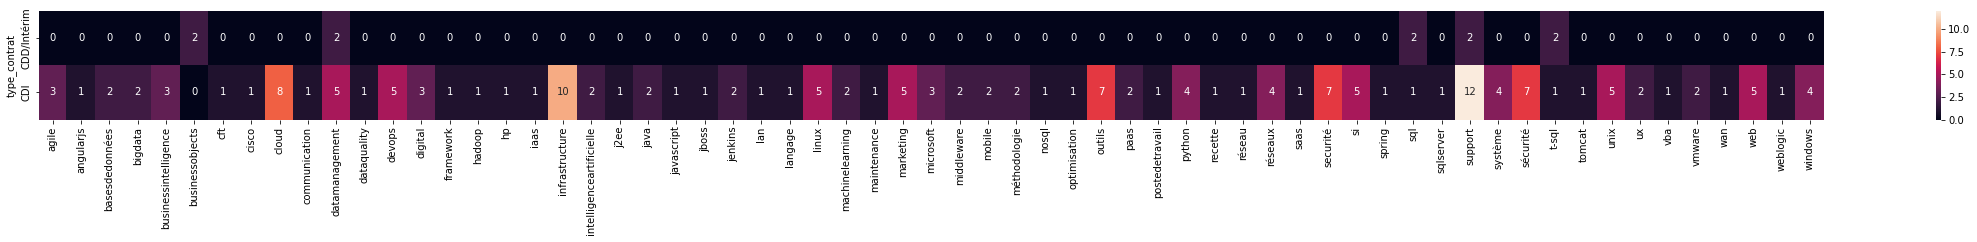

In [ ]:
df_contrat.drop(['nombre_competences', 'nombre_observations'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(40,2))
sns.heatmap(df_contrat, annot=True)

In [ ]:
#compétences recherchées par les entreprises qui recrutent le plus
df_salaire_entreprise = df_full.groupby(['entreprise']).sum()
df_salaire_entreprise.drop(['salaire_min', 'salaire_max'], axis=1, inplace=True)
#comme il y a beaucoup de colonnes compétences, on cherche à savoir combien de compétences sont présentes dans chaque ligne
#attention en cas de disparité entre les annonces, cette valeur peut être fortement influencée par le nombres d'observations
df_salaire_entreprise['nombre_competences'] = df_salaire_entreprise.astype(bool).sum(axis=1)
df_salaire_entreprise['nombre_observations'] = df_full['entreprise'].value_counts()
df_salaire_entreprise = df_salaire_entreprise.loc[:, (df_salaire_entreprise != 0).any(axis=0)]#.sort_values('salaire_max', ascending=False)
df_salaire_entreprise.sort_values('nombre_observations', ascending=False, inplace=True)
df_salaire_entreprise = df_salaire_entreprise.loc[df_salaire_entreprise['nombre_observations'] >= 7]#.style.background_gradient(cmap='Purples')
df_salaire_entreprise

,abap,access,acquisition,agile,aix,android,angularjs,apache,basesdedonnées,bigdata,...,video,vmware,wan,web,weblogic,webmarketing,windows,xml,nombre_competences,nombre_observations
entreprise,,,,,,,,,,,,,,,,,,,,,
Société générale,0,1,0,9,0,0,2,0,1,8,...,0,0,0,2,0,0,0,0,54,38
Uniware Global Services,0,0,0,0,0,0,0,1,0,0,...,0,2,1,1,1,0,3,0,36,20
Safran-Group,0,0,0,0,0,0,0,0,2,6,...,0,0,0,0,0,0,2,0,26,15
Naval Group,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13,9
TRIMANE,0,0,0,0,0,0,0,0,1,5,...,0,0,0,0,0,0,0,0,20,8
FED IT,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,13,8
ENGIE,1,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,20,8
EDF France,0,0,0,3,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,16,7


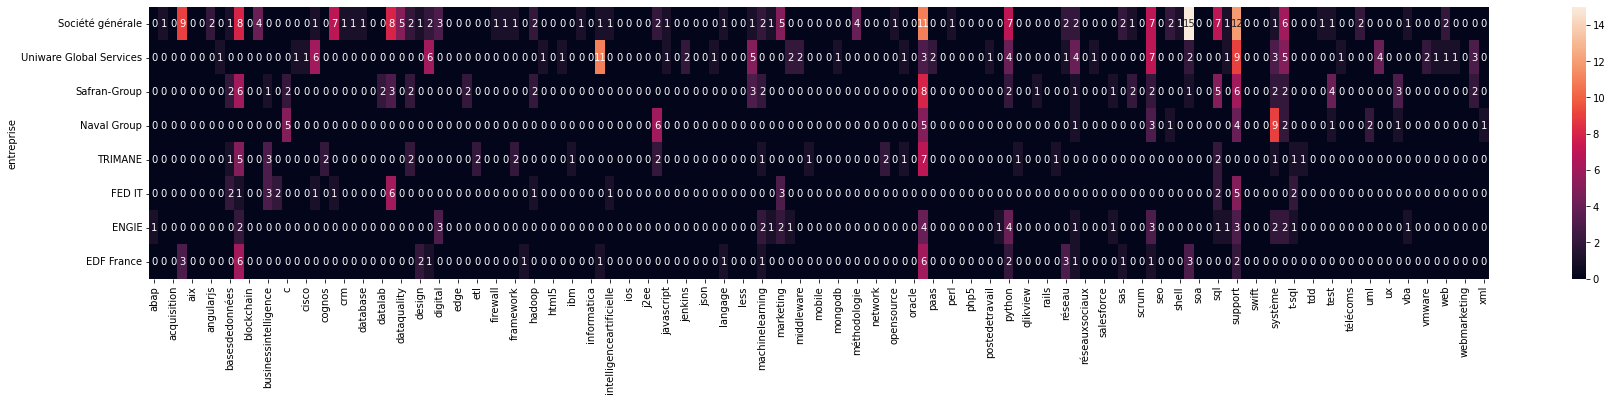

In [ ]:
df_salaire_entreprise.drop(['nombre_competences', 'nombre_observations'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(30,5))
sns.heatmap(df_salaire_entreprise, annot=True)


ANALYSE MULTIVARIEE

,entreprise,type_contrat,abap,access,acquisition,agile,aix,android,angularjs,apache,...,video,vmware,wan,web,weblogic,webmarketing,windows,xml,nombre_competences,nombre_observations
0,Air France,Contrat d'apprentissage,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,Aladium,CDD/Intérim,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,75.0,NaN
2,Amazon,CDI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN
3,BEEZEN,CDI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,Banque de France,CDI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,UMANIS,CDI,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,NaN,NaN
71,UTI GROUP,CDI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
72,Uniware Global Services,CDI,0,0,0,0,0,0,0,1,...,0,2,1,1,1,0,3,0,NaN,NaN
73,Vinci,CDI,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN


#PIPELINE

In [ ]:
# Preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler

# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



df_model = df.drop(['type_client'], axis=1).dropna()

y = df_model[["salaire_min","salaire_max"]]
#y = df_model["salaire_min"]
X = df_model.drop(["salaire_min","salaire_max", "date"], axis=1)

df_model.shape

(43, 8)

PIPELINE

In [ ]:
# create the pipeline
pipeline = Pipeline([
    ("regressor", TransformedTargetRegressor(regressor=RandomForestRegressor()))
])

COLONNE TRANSFORMER

In [ ]:
column_cat = ['Intitulé du poste','entreprise', 'type_contrat', 'lieu']
transfo_cat = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Transformation of textual variables
column_comp = 'competences'
transfo_comp = Pipeline(
    steps=[
    ('bow', CountVectorizer())
])

PREPARATION

In [ ]:
# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_cat', transfo_cat , column_cat),
        ('data_comp', transfo_comp , column_comp),
      
    ])

DECLARATION DU MODELE

In [ ]:


model = RandomForestRegressor()

multi_reg = MultiOutputRegressor(model)

pipe_model = Pipeline(steps=[('preparation', preparation),
                        ('model',model)])
pipe_model

"""
model = RandomForestRegressor()

pipe_model = Pipeline(steps=[('preparation', preparation),
                        ('model',model)])
pipe_model
"""

"\nmodel = RandomForestRegressor()\n\npipe_model = Pipeline(steps=[('preparation', preparation),\n                        ('model',model)])\npipe_model\n"

DIAGRAMME

In [ ]:
from sklearn import set_config
set_config(display='diagram')
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Intitulé du poste',
                                                   'entreprise', 'type_contrat',
                                                   'lieu']),
                                                 ('data_comp',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer())]),
                                                  'competences')])),
                ('model', RandomForestRegressor())])

ENTRAINEMENT DU MODELE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

#pipe_model = MultiOutputRegressor(model)

pipe_model.fit(X_train, y_train)


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Intitulé du poste',
                                                   'entreprise', 'type_contrat',
                                                   'lieu']),
                                                 ('data_comp',
                                                  Pipeline(steps=[('bow',
                                                                   CountVectorizer())]),
                                                  'competences')])),
                ('model', RandomForestRegressor())])

PREDICTIONS

In [ ]:
y_pred = pipe_model.predict(X_test)

EVALUATION DU MODELE

In [ ]:
score= r2_score(y_test, y_pred)
score

0.6101114444655247

UTILISATION DU MODELE

In [ ]:
new_data={
    'Intitulé du poste': 'data analyst',
  'competences': 'python, sql, agile, cloud',
  'entreprise': '',
       'type_contrat': 'CDD',
       'lieu': 'paris'}

df_pred = pd.DataFrame(new_data, index=[0])
df_pred

,Intitulé du poste,competences,entreprise,type_contrat,lieu
0,data analyst,"python, sql, agile, cloud",,CDD,paris


In [ ]:
pred_salaire = pipe_model.predict(df_pred)
pred_salaire[0]

array([39660., 59690.])

In [ ]:
df.to_csv("data_bdd.csv", index=False)